# Data Exploration

This code initializes a Spark session to load a CSV file containing feature-engineered housing data into a Spark DataFrame. It first checks if the specified file exists using Python's `os.path.exists`. If the file does not exist, it displays an error message and lists the contents of the parent directory for troubleshooting. If the file is found, it loads the data into a Spark DataFrame using `spark.read.csv` with headers and inferred schemas. The schema and a sample of the data are displayed to confirm successful loading. Next, the Spark DataFrame is converted to a Pandas DataFrame, allowing easier workflow with libraries like Matplotlib or Seaborn. This ensures the data is accessible and ready for further analysis.
We are also printing out top 5 rows of the data and listing out the column names to make sure we have all we need.

In [7]:
from pyspark.sql import SparkSession
import os

# Initialize Spark session
spark = SparkSession.builder \
    .appName("Load Spark Output") \
    .getOrCreate()

# Define the path to the CSV file
file_path = "../data/engineered/calgary_housing_features.csv"  

# Check if the file exists
if not os.path.exists(file_path):
    print(f"File does not exist: {file_path}")
    parent_dir = os.path.dirname(file_path)
    print(f"Parent directory contents: {os.listdir(parent_dir)}")
else:
    print(f"File exists: {file_path}. Loading data...")

    # Load the CSV file into a Spark DataFrame
    df_spark = spark.read.csv(file_path, header=True, inferSchema=True)

    # Show data from Spark DataFrame
    print("Data loaded into Spark DataFrame:")
    df_spark.printSchema()
    df_spark.show(5)

    # Convert to Pandas DataFrame for further analysis if needed
    print("Converting Spark DataFrame to Pandas...")
    df_pandas = df_spark.toPandas()
    print("Data converted to Pandas DataFrame. Displaying top rows:")
    print(df_pandas.head())


File exists: ../data/engineered/calgary_housing_features.csv. Loading data...
Data loaded into Spark DataFrame:
root
 |-- roll_year: integer (nullable = true)
 |-- roll_number: integer (nullable = true)
 |-- address: string (nullable = true)
 |-- assessed_value: double (nullable = true)
 |-- assessment_class: string (nullable = true)
 |-- assessment_class_description: string (nullable = true)
 |-- re_assessed_value: double (nullable = true)
 |-- comm_name: string (nullable = true)
 |-- land_use_designation: string (nullable = true)
 |-- property_type: string (nullable = true)
 |-- land_size_sm: double (nullable = true)
 |-- land_size_sf: double (nullable = true)
 |-- land_size_ac: double (nullable = true)
 |-- nr_assessed_value: double (nullable = true)
 |-- year_of_construction: integer (nullable = true)
 |-- sub_property_use: string (nullable = true)
 |-- fl_assessed_value: double (nullable = true)
 |-- property_age: integer (nullable = true)
 |-- price_per_sqft: double (nullable = t

## Visualization after Feature Engineering

Next we do some visualizations to explore the key features of the housing dataset. The first visualization uses Seaborn to plot a histogram with a kernel density estimate (KDE) for the `price_per_sqft` column. This distribution plot helps identify the spread and common values of property prices per square foot across the dataset. The second visualization is a scatter plot that shows the relationship between `property_age` and `assessed_value`, enabling an analysis of how the age of a property correlates with its assessed value. The final visualization is a bar chart showing the top 10 communities by their average assessed value, calculated by grouping the data by `comm_name` and finding the mean of `avg_comm_value`. The bar chart provides an overview of the communities with the highest property assessments, offering insights into regional trends.

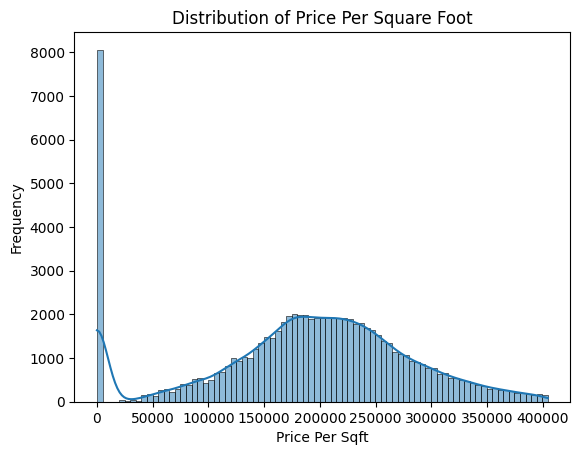

In [8]:
import seaborn as sns
import matplotlib.pyplot as plt

# Visualize price per square foot distribution
sns.histplot(df_pandas["price_per_sqft"], kde=True)
plt.title("Distribution of Price Per Square Foot")
plt.xlabel("Price Per Sqft")
plt.ylabel("Frequency")
plt.show()


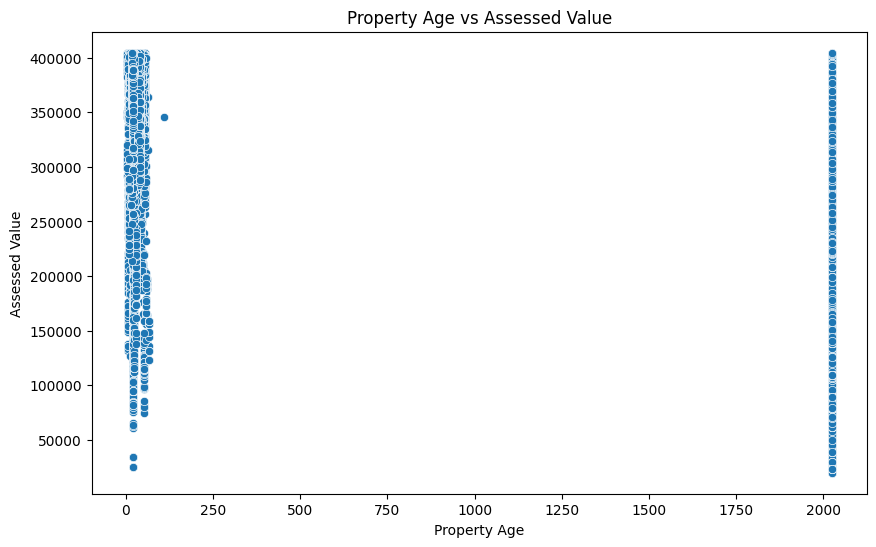

In [9]:
# Visualize property age vs assessed value
plt.figure(figsize=(10, 6))
sns.scatterplot(x=df_pandas["property_age"], y=df_pandas["assessed_value"])
plt.title("Property Age vs Assessed Value")
plt.xlabel("Property Age")
plt.ylabel("Assessed Value")
plt.show()

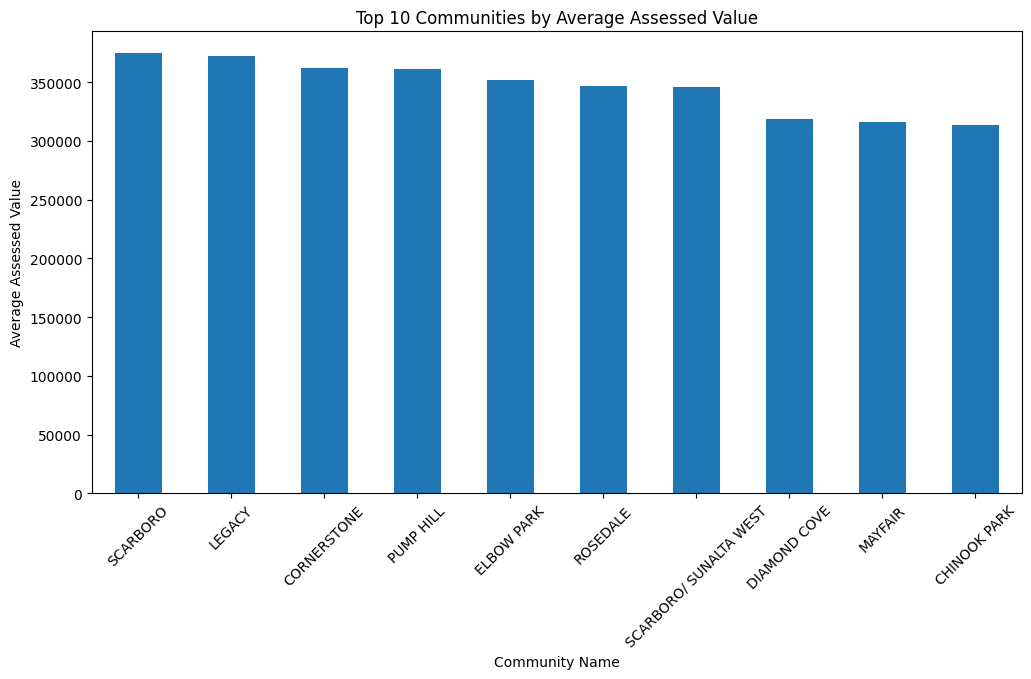

In [10]:

# Visualize average community value (bar chart)
avg_comm_value = df_pandas.groupby("comm_name")["avg_comm_value"].mean().sort_values(ascending=False).head(10)
avg_comm_value.plot(kind="bar", figsize=(12, 6))
plt.title("Top 10 Communities by Average Assessed Value")
plt.xlabel("Community Name")
plt.ylabel("Average Assessed Value")
plt.xticks(rotation=45)
plt.show()

## Predictions visualization for pipeline running

Here, we are analyzying and visualizing the predictions from the machine learning model we made using pipeline.py file and it uses linear-regression model. The predictions are stored in sharded CSV files in the specified `predictions_path`. To handle this, the script uses the `glob` module to locate all parts of the sharded data and combines them into a single Pandas DataFrame. The combined data is then standardized by renaming the columns to ensure consistency and converting the `re_assessed_value` and `prediction` columns to numeric types for accurate visualization.

The visualization is a scatter plot that compares the actual (`re_assessed_value`) and predicted (`prediction`) values of the re-assessed property values. This plot helps assess the model's performance by showing how closely the predictions align with the actual values. Additionally, a red dashed line is added to represent a "perfect prediction" line, where the predicted values equal the actual values. The closer the points are to this line, the better the model's accuracy.

Reading prediction data from: ../data/predictions/re_assessed_value_predictions.csv/


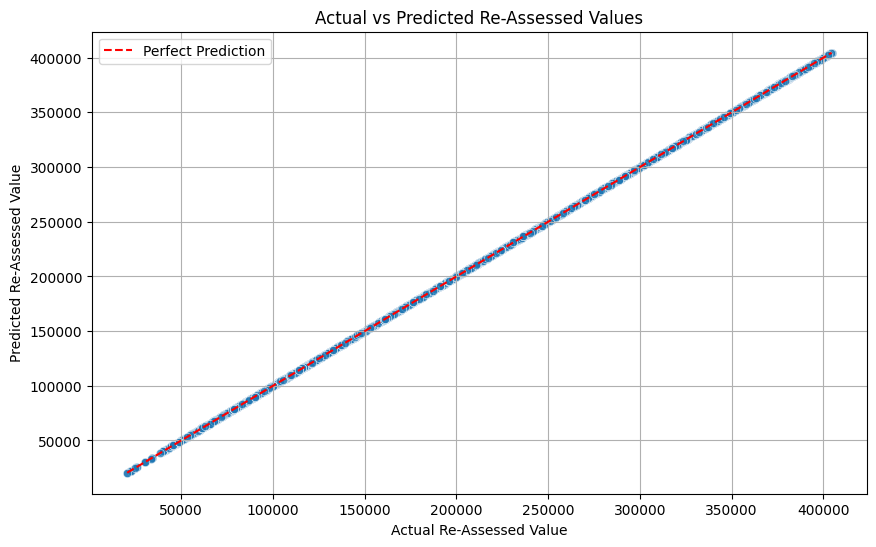

In [11]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import glob
import os

# Load predictions from sharded CSV file
predictions_path = "../data/predictions/re_assessed_value_predictions.csv/" 
print(f"Reading prediction data from: {predictions_path}")

# Combine all sharded parts into a single DataFrame
all_parts = glob.glob(os.path.join(predictions_path, "part-*"))
predictions_pandas = pd.concat([pd.read_csv(part) for part in all_parts], ignore_index=True)

# Ensure column names are consistent and correct
predictions_pandas.columns = ["features", "re_assessed_value", "prediction"]

# Convert necessary columns to numeric for visualization
predictions_pandas["re_assessed_value"] = pd.to_numeric(predictions_pandas["re_assessed_value"])
predictions_pandas["prediction"] = pd.to_numeric(predictions_pandas["prediction"])

# Scatter plot: Actual vs Predicted
plt.figure(figsize=(10, 6))
sns.scatterplot(x="re_assessed_value", y="prediction", data=predictions_pandas, alpha=0.7)
plt.title("Actual vs Predicted Re-Assessed Values")
plt.xlabel("Actual Re-Assessed Value")
plt.ylabel("Predicted Re-Assessed Value")
plt.plot([predictions_pandas["re_assessed_value"].min(), predictions_pandas["re_assessed_value"].max()],
         [predictions_pandas["re_assessed_value"].min(), predictions_pandas["re_assessed_value"].max()],
         color="red", linestyle="--", label="Perfect Prediction")
plt.legend()
plt.grid(True)
plt.show()


## Residuals Visualization

Here, we are creating a histogram to visualize the distribution of residuals, which are the differences between the actual (`re_assessed_value`) and predicted (`prediction`) values. The residuals are calculated as `residuals = re_assessed_value - prediction` and added as a new column to the Pandas DataFrame.

The histogram, enhanced with a kernel density estimate (KDE), provides insights into how well the model's predictions align with the actual values. If the model performs well, the residuals should center around zero, indicating that the predictions are unbiased. The distribution's spread reflects the model's error magnitude, with narrower distributions suggesting better predictive performance.

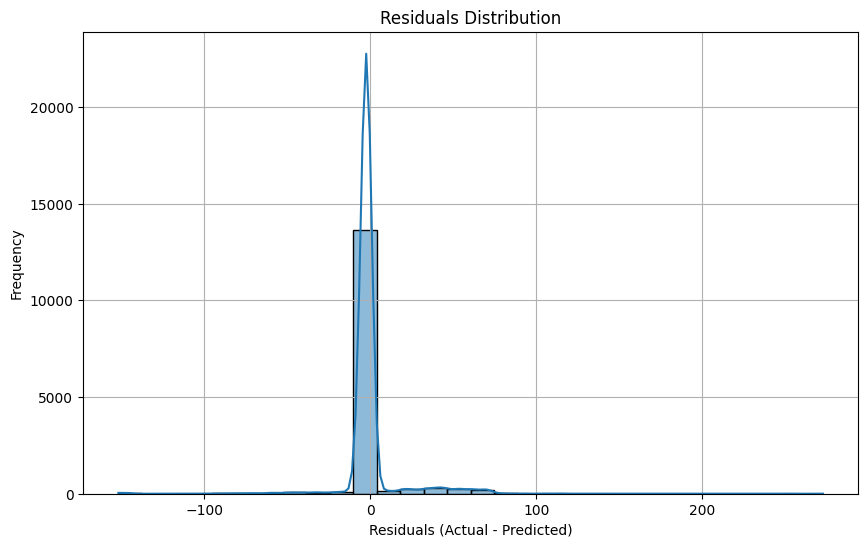

In [12]:
# Residuals distribution
predictions_pandas["residuals"] = predictions_pandas["re_assessed_value"] - predictions_pandas["prediction"]
plt.figure(figsize=(10, 6))
sns.histplot(predictions_pandas["residuals"], kde=True, bins=30)
plt.title("Residuals Distribution")
plt.xlabel("Residuals (Actual - Predicted)")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()

## Residuals vs Predictions

Here, we will be creating a scatter plot to visualize the relationship between the residuals (`re_assessed_value - prediction`) and the predicted values (`prediction`). Each point represents a prediction, with its x-coordinate being the predicted value and the y-coordinate being the residual.

The plot includes a red horizontal line at `y=0` to indicate the ideal scenario where residuals are zero, meaning the predictions perfectly match the actual values. A random, evenly distributed scatter of points around this line suggests that the model's errors are unbiased across the range of predicted values. Patterns, clusters, or trends in the residuals (e.g., a funnel shape or a curve) may indicate model inadequacies, such as heteroscedasticity or non-linearity. The grid lines and labeled axes provide clarity for interpreting the plot and identifying any systematic errors in the model's predictions.

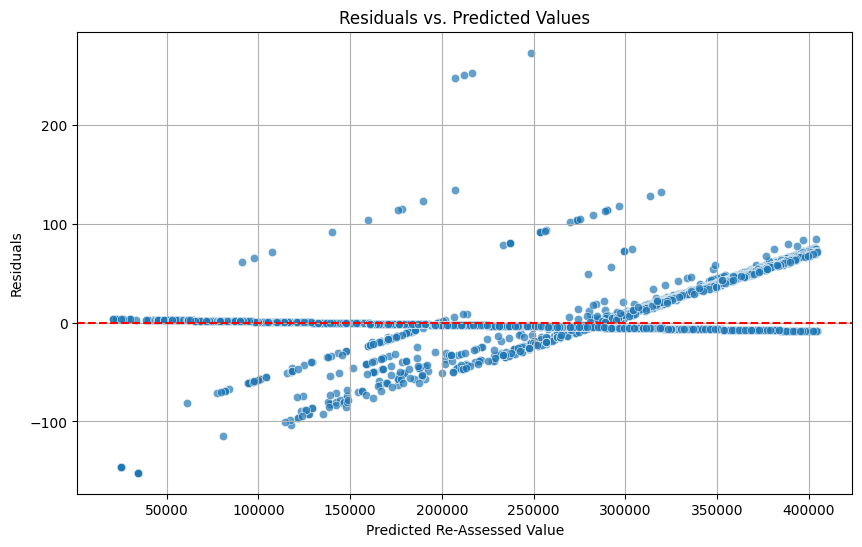

In [13]:

# Residuals vs. Predicted
plt.figure(figsize=(10, 6))
sns.scatterplot(x="prediction", y="residuals", data=predictions_pandas, alpha=0.7)
plt.axhline(0, color="red", linestyle="--")
plt.title("Residuals vs. Predicted Values")
plt.xlabel("Predicted Re-Assessed Value")
plt.ylabel("Residuals")
plt.grid(True)
plt.show()